In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def MA(X, mu, theta, order):
    T = len(X)

    res = np.zeros(T)
    eps = X - mu

    for t in range(T):
        if t < order:
            res[t] = mu + eps[t]
        else:
            res[t] = mu + np.dot(theta,eps[t-order:t][::-1])
    return res

In [3]:
def ma_neg_log_likelihood(params, X, order):
    mu = params[0]
    theta = params[1:order+1]
    sigma2 = params[-1]**2

    T = len(X)
    eps = np.zeros(T)

    
    
    for t in range(T):
        if t < order:
            eps[t] = X[t] - mu
        else:
            
            
            eps[t] = X[t] - mu - np.dot(theta,eps[t-order:t][::-1])
        
    nll = T/2*np.log(2*np.pi*sigma2) + 1/2/sigma2*np.sum(eps**2)

    return nll

In [4]:
def fit_ma_model(X, order):
    mu_seed = np.mean(X)
    sigma_seed = np.std(X)
    rng = np.random.default_rng(seed=42)
    theta_seed = rng.random(size=order)*0.1

    params_init = np.concatenate(([mu_seed], theta_seed, [sigma_seed]))

    params_bounds = [(-1e2, 1e2)] * (order + 1) + [(1e-7, np.inf)]
    #print(params_init)
    result = minimize(ma_neg_log_likelihood,
                      params_init,
                      bounds = params_bounds,
                      args=(X,order),
                       method='L-BFGS-B')
    return result.x[0], result.x[1:order+1], result.x[-1]
    
    

In [5]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1).dropna()
test = pd.read_csv('./x_test.csv', index_col='ID').dropna()

In [6]:
series = x_train[x_train['DATE']==0]
series = series[series['STOCK']==2]
cols_idx = ['RET_%i' % i for i in range(1,21)]
series = series[cols_idx]

In [7]:
series.head()

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,RET_11,RET_12,RET_13,RET_14,RET_15,RET_16,RET_17,RET_18,RET_19,RET_20
ID,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.014331,-0.017215,-0.018433,0.134146,0.182287,0.01357,0.030108,0.027624,-0.04937,-0.028571,0.059459,0.003254,0.008752,-0.012959,-0.002155


In [8]:
order = 10
#signal = series.values[0,-order:]
signal = series.values[0,:]
mu = np.mean(signal)
np.random.seed(10219321)
sigma = np.std(signal)
eps = signal - sigma
rng = np.random.default_rng(seed=42)
theta = rng.random(size=order)*0.1
params = [mu,*theta,sigma]

In [9]:
ma_neg_log_likelihood(params,signal,order)

-30.25732611743676

In [10]:
mu, theta, sigma = fit_ma_model(signal,order)

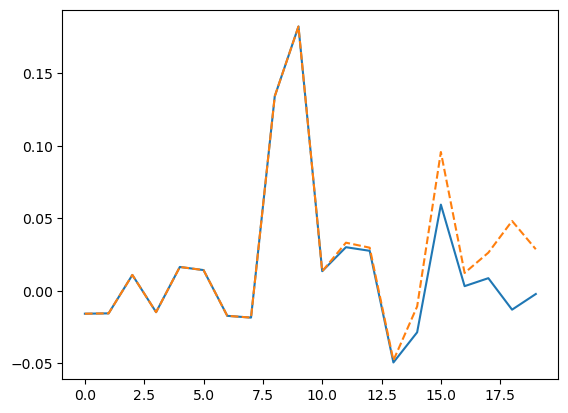

In [11]:
fig, ax = plt.subplots()
ax.plot(signal)
ax.plot(MA(signal, mu, theta, order),'--')

In [15]:
theta

array([-0.21511843, -0.19739995, -0.13059878, -0.10129125, -0.64856181,
        0.25615848, -0.19191346, -0.08998479, -0.13068549, -0.19324851])

In [16]:
theta[1:-1][::-1]

array([-0.13068549, -0.08998479, -0.19191346,  0.25615848, -0.64856181,
       -0.10129125, -0.13059878, -0.19739995])

In [17]:
mu + np.dot(theta,signal[-order:])

0.054698929083918324

In [18]:
y_train

,RET
ID,
0,True
1,True
2,False
3,False
4,False
...,...
418590,False
418591,False
418592,True


In [21]:
np.r_[1,theta]

array([ 1.        , -0.21511843, -0.19739995, -0.13059878, -0.10129125,
       -0.64856181,  0.25615848, -0.19191346, -0.08998479, -0.13068549,
       -0.19324851])

In [7]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

In [8]:
arparams = np.array([0.75, -0.25])
maparams = np.array([0.65, 0.35])

In [9]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
nobs = 250
y = arma_generate_sample(arparams, maparams, nobs)

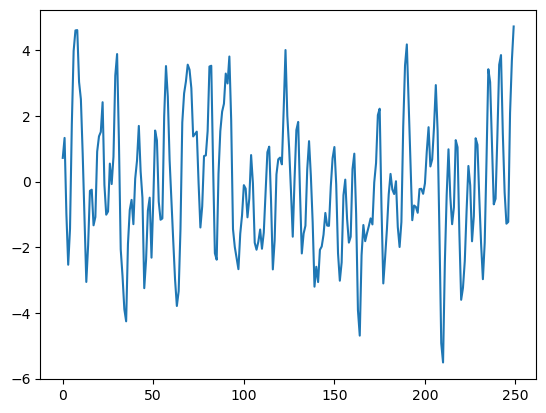

In [10]:
fig, ax = plt.subplots()
ax.plot(y)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
model = ARIMA(series.values[0], order = (5,0,5))
res = model.fit()

/home/alextusnin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alextusnin/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(5, 0, 5)   Log Likelihood                  35.639
Date:                Sun, 24 Nov 2024   AIC                            -47.279
Time:                        12:36:25   BIC                            -35.330
Sample:                             0   HQIC                           -44.946
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0210      0.017      1.264      0.206      -0.012       0.054
ar.L1          0.1126      2.028      0.056      0.956      -3.861       4.086
ar.L2         -0.3371      3.374     -0.100      0.9

In [24]:
forecast = res.forecast(steps=10)

In [25]:
series.values[0]

array([-0.01574804, -0.01550388,  0.01097159, -0.01467163,  0.01648332,
        0.01433121, -0.01721459, -0.0184328 ,  0.13414591,  0.18228661,
        0.01356968,  0.03010808,  0.02762432, -0.04936977, -0.02857144,
        0.05945949,  0.0032538 ,  0.00875246, -0.01295897, -0.00215544])

In [26]:
forecast

array([0.02308254, 0.03227767, 0.02627106, 0.04129477, 0.03051676,
       0.01651322, 0.01852686, 0.02449117, 0.02205842, 0.01899433])

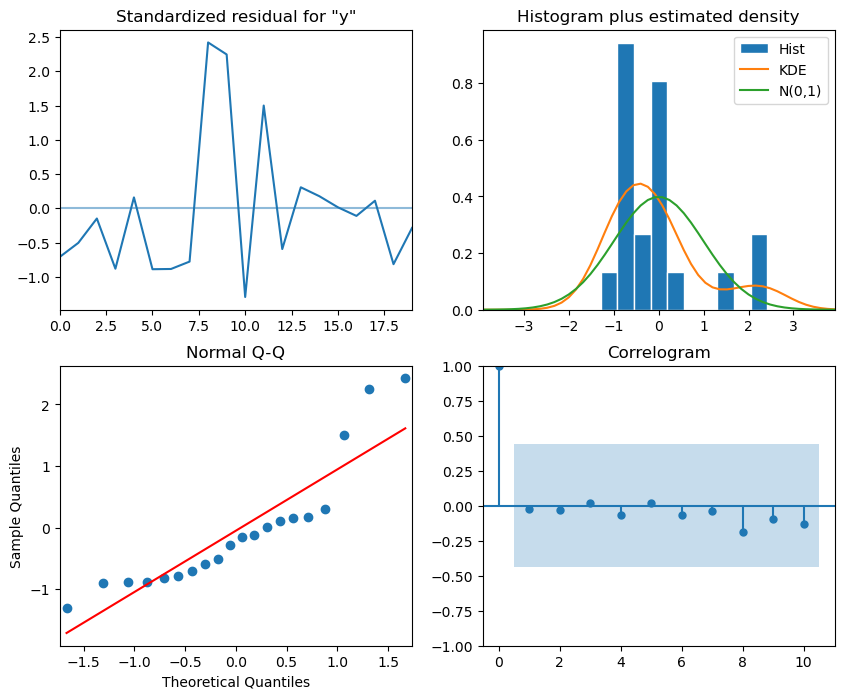

In [27]:
res.plot_diagnostics(figsize=(10, 8))
plt.show()